In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import Model, config
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Input, LSTM, Dropout, Dense, Attention, Concatenate, Reshape, Lambda, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import regularizers
from tensorflow.keras.regularizers import l2
import os
from tensorflow.keras.models import load_model
import pickle


In [2]:
data = pd.read_csv('data_for_lstm.csv')
data.set_index('Date', inplace = True)
data.sort_index()
data.head()

,Arrivals (Tonnes),Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal),Variety_(Red Nanital),Variety_Chips,Variety_Desi,Variety_Jyoti,Variety_Local,Variety_Other,...,Market_Indore,Market_Indore(F&V),Market_Mhow,Market_Sanwer,year,month,day,dayofweek,weekofyear,quarter
Date,,,,,,,,,,,,,,,,,,,,,
2002-11-01,115.500,350.0,750.0,525.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2002,11,1,4,44,4
2002-11-02,115.000,400.0,750.0,575.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2002,11,2,5,44,4
2002-11-03,111.375,412.5,762.5,587.5,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2002,11,3,6,44,4
2002-11-04,107.750,425.0,775.0,600.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2002,11,4,0,45,4
2002-11-05,104.125,437.5,787.5,612.5,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2002,11,5,1,45,4


In [3]:
# seperate dependents and independents features...
X = data.drop(['Modal Price (Rs./Quintal)', 'Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)'], axis=1)
y = data['Modal Price (Rs./Quintal)'] 

## Before training the model, split the data into training and test set to avoid the data leackage

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [4]:
scaler1 = StandardScaler()
X_trained_scaled = scaler1.fit_transform(X_train) 
X_test_scaled = scaler1.transform(X_test) 

In [5]:
scaler2 = StandardScaler()
y_train_scaled = scaler2.fit_transform(np.array(y_train).reshape(-1,1))
y_test_scaled = scaler2.transform(np.array(y_test).reshape(-1,1))

### RandomForest Model...

In [6]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_trained_scaled, y_train_scaled.ravel())

RandomForestRegressor(random_state=42)

In [7]:
y_pred = model.predict(X_test_scaled)

# Calculate the performance metrics
mae = mean_absolute_error(y_test_scaled, y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = mse ** 0.5

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 0.1163591232815997
Mean Squared Error: 0.06308711893888592
Root Mean Squared Error: 0.25117149308567227


In [8]:
y_pred_inv = scaler2.inverse_transform(y_pred.reshape(-1,1))
y_pred_inv

array([[1219.40590909],
       [ 244.14655172],
       [ 799.875     ],
       ...,
       [1707.156     ],
       [ 700.5786    ],
       [ 810.        ]])

### LSTM model

In [37]:
data = pd.read_csv('data_for_lstm.csv')
data.set_index('Date', inplace = True)
data.sort_index()
data['modal_price (Rs./Quitnal)'] = data['Modal Price (Rs./Quintal)']
data.drop(['Min Price (Rs./Quintal)', 'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)'], axis=1,inplace=True)
data.to_csv('data_for_lstm_model1.csv')
data.head()

,Arrivals (Tonnes),Variety_(Red Nanital),Variety_Chips,Variety_Desi,Variety_Jyoti,Variety_Local,Variety_Other,Variety_Potato,Variety_Red,Market_Gautampura,...,Market_Indore(F&V),Market_Mhow,Market_Sanwer,year,month,day,dayofweek,weekofyear,quarter,modal_price (Rs./Quitnal)
Date,,,,,,,,,,,,,,,,,,,,,
2002-11-01,115.500,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2002,11,1,4,44,4,525.0
2002-11-02,115.000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2002,11,2,5,44,4,575.0
2002-11-03,111.375,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2002,11,3,6,44,4,587.5
2002-11-04,107.750,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2002,11,4,0,45,4,600.0
2002-11-05,104.125,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,2002,11,5,1,45,4,612.5


In [7]:
## Split the data into train and test dataframe
train_size = int(len(data)*0.85)
train_df = data[: train_size]
test_df = data[train_size : ]


In [8]:
# Normalize the features
scaler0 = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler0.fit_transform(train_df)
scaled_test_data = scaler0.transform(test_df)

# Save the scaler to a file
with open('minmax_scaler0.pkl', 'wb') as f:
    pickle.dump(scaler0, f)

In [9]:
## Defuine an input method
def create_database(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback : i, :-1])
        y.append(np.mean(data[i-lookback:i, -1])) # Moving average

    return np.array(X), np.array(y)


In [10]:
## Define look back period
lookback_period = 4

X_train, y_train = create_database(scaled_train_data, lookback_period)
X_test, y_test = create_database(scaled_test_data, lookback_period)

In [11]:
print(X_train.shape, y_train.shape)

(6729, 4, 20) (6729,)


In [46]:

@tf.keras.utils.register_keras_serializable()
def custom_lambda_function(x):
    # Custom operation that preserves the shape (None, 4, 128)
    # For example, let's apply a normalization along the feature axis
    return tf.nn.l2_normalize(x, axis=-1)


# Define the LSTM model with attention mechanism
def create_attention_lstm_model(input_shape, units=50, dropout_rate=0.3, learning_rate=0.001):
    inputs = Input(shape=input_shape)
    
    # Encoder LSTM
    lstm_out = LSTM(units, return_sequences=True, kernel_regularizer=l2(0.01))(inputs)
    lstm_out = Dropout(dropout_rate)(lstm_out)
    
    # Attention Layer
    attention = Attention()([lstm_out, lstm_out])
    print(attention.shape)
    context_vector = Lambda(custom_lambda_function,name = 'custom_lambda', output_shape=(input_shape[0], units))(attention)
    print('context shape', context_vector.shape)
    # context_vector = Reshape((1, units))(context_vector)

    lstm_out = LSTM(units // 2, return_sequences=False, kernel_regularizer=l2(0.01))(attention)
    lstm_out = Dropout(dropout_rate)(lstm_out)
    print("lstm out", lstm_out.shape)
    # Dense output layer
    outputs = Dense(1)(lstm_out)
    outputs = LeakyReLU(negative_slope=0.1)(outputs)
    
    # Compile the model
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [47]:
## Define a method to load or train model...

def train_or_load_model(model_file, units_list, dropout_rates, batch_sizes, input_shape, epochs, X_train, y_train, X_test, y_test):
    # freeup the resources and reset the state of default keras backend
    tf.keras.backend.clear_session()
    
    if os.path.exists(model_file):        
        print(f"Loading existing model from {model_file}")
        
        custom_objects = {'custom_lambda_function': custom_lambda_function}  # defined-above

        try:
            # Enable unsafe deserialization
            config.enable_unsafe_deserialization()
            model = load_model(model_file, custom_objects=custom_objects)
            
        except Exception as e:
            print(f"Error loading model: {e}")
            model = None

        return model, None, None
    
    else:
        print("No existing model found. Training a new model.")
        best_mae = float("inf")
        best_params = {}
        best_model = None

        # Loop over different combinations of hyperparameters
        for units in units_list:
            for dropout_rate in dropout_rates:
                for batch_size in batch_sizes:
                    print(f"Training with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}")

                    # Create the model
                    model = create_attention_lstm_model(input_shape=input_shape,
                                                        units=units, dropout_rate=dropout_rate)
                    
                    # Define callbacks
                    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
                    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
                    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
                    
                    # Train the model
                    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, 
                                        callbacks=[checkpoint, early_stopping, reduce_lr], verbose=1)

                    plt.figure(figsize=(10, 6))
                    plt.plot(history.history['loss'], label='Training Loss')
                    plt.plot(history.history['val_loss'], label='Validation Loss')
                    plt.xlabel('Epochs')
                    plt.ylabel('Loss')
                    plt.legend()
                    plt.title(f'Training and Validation Loss with units={units}, dropout_rate={dropout_rate} and batch_size={batch_size}')
                    plt.show()
                    
                    # Evaluate the model
                    y_pred = model.predict(X_test)
                    y_pred = np.squeeze(np.mean(y_pred, axis=1))  # Changing shape equivalent to y_test (mean of timesteps and remove last dimension)
                    print(y_pred)
                    mae = mean_absolute_error(y_test, y_pred)
                    print(mae)
                    # Store the best parameters
                    if mae < best_mae:
                        best_mae = mae
                        best_params = {
                            'units': units,
                            'dropout_rate': dropout_rate,
                            'batch_size': batch_size
                        }
                        best_model = model
        
        # Save the best model
        if best_model:
            best_model.save(model_file)
        
        print(f"Best MAE: {best_mae} with parameters: {best_params}")

        return best_model, best_params, best_mae


No existing model found. Training a new model.
Training with units=128, dropout_rate=0.3, batch_size=32
(None, 4, 128)
context shape (None, 4, 128)
lstm out (None, 64)
Epoch 1/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9914
Epoch 1: val_loss improved from inf to 0.03451, saving model to best_attention_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.9883 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 2/5
166/169 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148
Epoch 2: val_loss did not improve from 0.03451
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0147 - val_loss: 0.0353 - learning_rate: 0.0010
Epoch 3/5
166/169 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0111
Epoch 3: val_loss improved from 0.03451 to 0.02640, saving model to best_attention_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0111 - val_loss: 0.0264 - learning_rate: 0.0010
Epoch 4/5
162/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107
Epoch 4: val_loss improved from 0.026

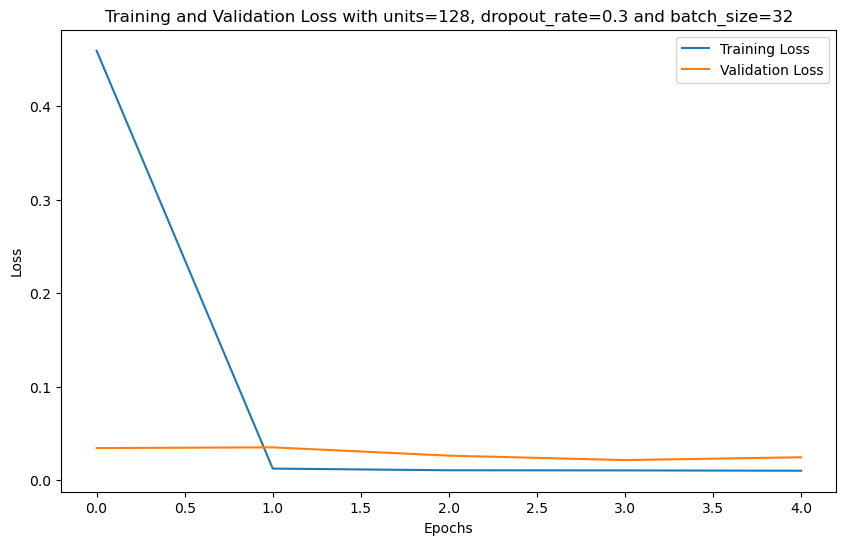

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
[0.45847777 0.3683901  0.41692623 ... 0.7466451  0.7413106  0.7358801 ]
0.13937908341806843
Best MAE: 0.13937908341806843 with parameters: {'units': 128, 'dropout_rate': 0.3, 'batch_size': 32}
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Absolute Error: 0.13937908341806843
Mean Squared Error: 0.05441134611092066
Root Mean Squared Error: 0.23326239755031383


In [49]:
## Define model file path
model_file = 'best_attention_model.keras'

# Parameters to try
unit_lists = [128]
dropout_rates = [0.3]
batch_sizes = [32]
epochs = 5

timesteps = X_train.shape[1]
features = X_train.shape[2]
input_shape = (timesteps, features)

# Call the above funtion to train and load model with parameter defined above.
best_model, best_params, best_mae = train_or_load_model(model_file, unit_lists, dropout_rates, batch_sizes, input_shape, 
                                                        epochs, X_train, y_train, X_test, y_test)

# Make predictions and evaluate the model
if best_model:
    y_pred = best_model.predict(X_test)
    y_pred = y_pred.ravel()
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
else:
    print("Model could not be trained or loaded.")


In [19]:
print(best_params)

{'units': 128, 'dropout_rate': 0.3, 'batch_size': 32}


In [18]:
def create_dummy_features(y, n_features):
    dummy_features = np.zeros((y.shape[0], n_features-1))
    return np.hstack((dummy_features, y.reshape(-1,1)))

In [19]:
y_test_dummy = create_dummy_features(y_test, 21)
y_pred_dummy = create_dummy_features(y_pred, 21)

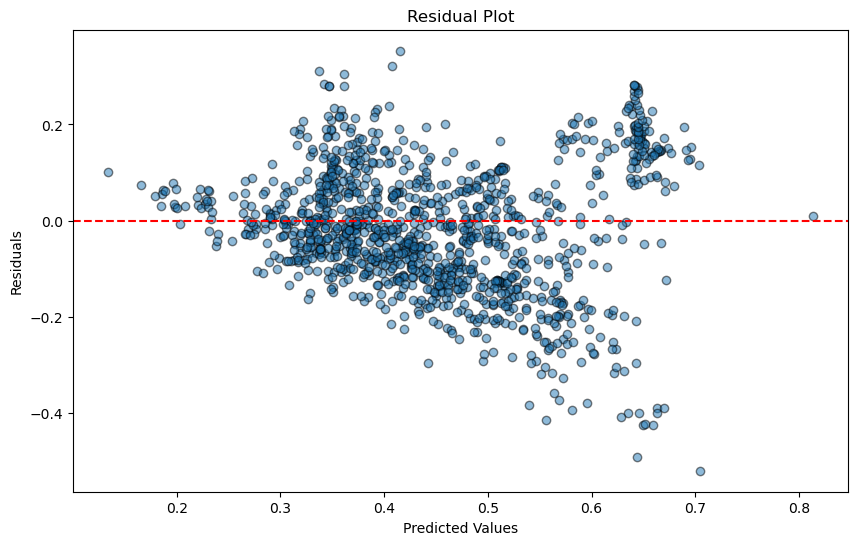

In [20]:
residuals = y_test - y_pred

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

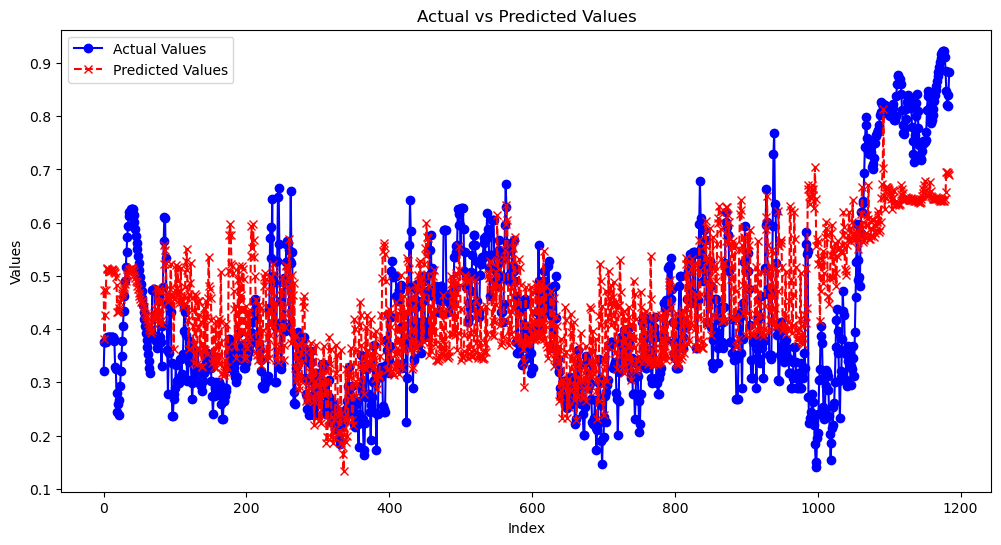

In [22]:
# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot actual vs predicted values
plt.plot(y_test, label='Actual Values', color='blue', linestyle='-', marker='o')
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--', marker='x')

# Add labels, legend, and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.savefig('real_vs_pred_wnf0.png')
# Show plot
plt.show()